In [38]:
import numpy as np
from scipy.optimize import linprog

def objective_function(x):
    return 2 * abs(1 - x[0]) + (1 - x[1])**4

def subgradient(x):
    return np.array([-2 if x[0] < 1 else 2, -4 * (1 - x[1])**3])

def constraints(x):
    return np.array([
        2 - x[1],
        x[1] + x[0] - 1,
        x[1] - x[0] + 3,
        x[1],
        x[0] + 1 - x[1],
        -x[0] + 4 - x[1]
    ])

def project_to_feasible(x):
    # Define the constraints for linprog
    A_ub = np.array([
        [0, -1],   # y <= 2
        [-1, -1],  # y >= -x + 1
        [1, -1],   # y >= x - 3
        [0, -1],   # y >= -1
        [1, 1],    # y <= x + 1
        [-1, 1]    # y <= -x + 3
    ])
    b_ub = np.array([2, -1, 3, 0, 1, 4])

    # Objective: minimize distance to x
    c = np.array([-x[0], -x[1]])

    # Solve the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, method='highs')

    if res.success:
        return res.x
    else:
        raise ValueError("Failed to project point onto feasible region")

def optimize_ellipsoid(max_iterations=25, tolerance=1e-2):
    n = 2  # dimension
    x = np.array([1.5, 1.2])  # initial point
    A = 100 * np.eye(n)  # initial ellipsoid matrix
    path = [x]
    
    for k in range(max_iterations):
    
        # Check constraints
        constraint_values = constraints(x)
        if np.all(constraint_values >= 0):
            # If all constraints are satisfied, use objective function gradient
            g = subgradient(x)
        
        # Compute step size
        Ag = A @ g
        step_size = 1 / ((n + 1) * np.sqrt(g @ Ag))
        
        # Update x
        x_new = x - step_size * Ag
        
        print(x_new)
        
        # Project x_new back to feasible region if necessary
        if np.any(constraints(x_new) < 0):
            x_new = project_to_feasible(x_new)
        
        # Update A
        A = n**2 / (n**2 - 1) * (A - 2 / (n + 1) * np.outer(Ag, Ag) / (g @ Ag))
        
        # Check for convergence
        if np.linalg.norm(x - x_new) < tolerance:
            break
        
        x = x_new
        
        path.append(x)
    
    return x, path

# Run the optimization
optimal_point, path = optimize_ellipsoid()
optimal_value = objective_function(optimal_point)

print(f"Optimal point: {optimal_point}")
print(f"Optimal value: {optimal_value}")

[-1.83290675  1.14667349]
[2.22279089 0.92892528]
[0.74093373 0.98587519]
[1.72884538 0.96719219]
[1.07023775 0.98371162]
[0.63116573 0.98811829]
[0.92388041 0.98773803]
[1.11902354 0.98762629]
[0.98892812 0.99407562]
[1.07565841 0.99694684]
[1.01783822 0.99664523]
[0.97929142 0.99657097]
[1.00498929 0.99875079]
[0.98785738 0.99960421]
[0.99927865 0.99925479]
[1.00689283 0.99909865]
Optimal point: [0.99927865 0.99925479]
Optimal value: 0.001442701555106593


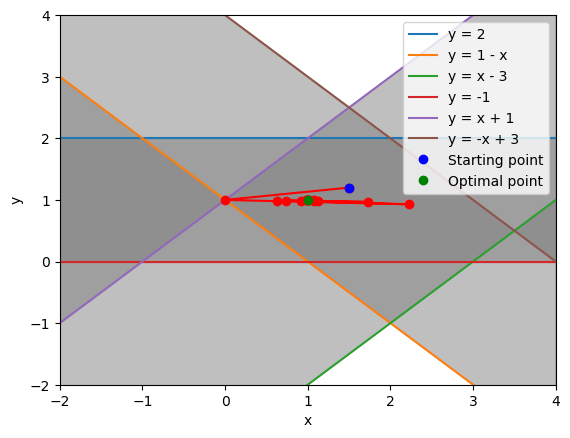

In [39]:
# graph the region

import matplotlib.pyplot as plt

x = np.linspace(-2, 4, 100)
y1 = 2 * np.ones_like(x)
y2 = 1 - x
y3 = x - 3
y4 = 0 * np.ones_like(x)
y5 = x + 1
y6 = -x + 4

plt.plot(x, y1, label='y = 2')
plt.plot(x, y2, label='y = 1 - x')
plt.plot(x, y3, label='y = x - 3')
plt.plot(x, y4, label='y = -1')
plt.plot(x, y5, label='y = x + 1')
plt.plot(x, y6, label='y = -x + 3')
plt.fill_between(x, y1, y4, color='gray', alpha=0.5)
plt.fill_between(x, y2, y5, color='gray', alpha=0.5)
plt.fill_between(x, y3, y6, color='gray', alpha=0.5)
plt.xlim(-2, 4)
plt.ylim(-2, 4)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# plot the path, starting point, and optimal point
path = np.array(path)
plt.plot(path[:, 0], path[:, 1], 'ro-')
plt.plot(path[0, 0], path[0, 1], 'bo', label='Starting point')
plt.plot(optimal_point[0], optimal_point[1], 'go', label='Optimal point')
plt.legend()

plt.show()